In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 8
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(0).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
ALPHA = 0.1

In [20]:
"""MobileNet v2 models for Keras.
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""

'MobileNet v2 models for Keras.\n# Reference\n- [Inverted Residuals and Linear Bottlenecks Mobile Networks for\n   Classification, Detection and Segmentation]\n   (https://arxiv.org/abs/1801.04381)\n'

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [22]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [23]:
def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)

In [24]:
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)

In [25]:
def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x

In [26]:
def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)

    return x

In [27]:
def MobileNetv2(input_shape, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = Input(shape=input_shape)

    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280

    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)

    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)

    model = Model(inputs, output)

    return model

In [28]:
model = MobileNetv2((IMAGE_HEIGHT, IMAGE_WIDTH, 168), NUM_VARIETIES, ALPHA)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 8)    12104       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 depthwise_conv2d_3 (DepthwiseC  (None, 4, 4, 12)    120         ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_11 (BatchN  (None, 4, 4, 12)    48          ['depthwise_conv2d_3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 4, 4, 12)     0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 4, 4, 3)      39          ['activation_8[0][0]']           
                                                                                                  
 batch_nor

                                                                                                  
 activation_15 (Activation)     (None, 2, 2, 36)     0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 depthwise_conv2d_7 (DepthwiseC  (None, 2, 2, 36)    360         ['activation_15[0][0]']          
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_23 (BatchN  (None, 2, 2, 36)    144         ['depthwise_conv2d_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 2, 2, 36)     0           ['batch_normalization_23[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_23 (Conv2D)             (None, 2, 2, 54)     540         ['batch_normalization_33[0][0]'] 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2, 2, 54)    216         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 2, 2, 54)     0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 depthwise_conv2d_11 (Depthwise  (None, 2, 2, 54)    540         ['activation_23[0][0]']          
 Conv2D)  

 conv2d_30 (Conv2D)             (None, 1, 1, 16)     1552        ['activation_30[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 1, 1, 16)    64          ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 1, 1, 16)     0           ['batch_normalization_45[0][0]', 
                                                                  'batch_normalization_42[0][0]'] 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 1, 1, 96)     1632        ['add_8[0][0]']                  
                                                                                                  
 batch_nor

In [29]:
import timeit
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [30]:
from keras.optimizers import Adam
adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [31]:
import matplotlib.pyplot as plt
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [32]:
history_dataframe = pd.DataFrame() 

In [33]:
tic = timeit.default_timer()

for x in range(0,2):
    print("\nEpoch: ",x+1)
    history = model.fit(train_dataset, train_dataset_label, batch_size=BATCH_SIZE, epochs = 1, validation_split=0.2, verbose=2)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)

toc = timeit.default_timer()
show_time(tic,toc)


Epoch:  1
2/2 - 14s - loss: 1.7205 - accuracy: 0.4167 - val_loss: 1.3882 - val_accuracy: 0.0000e+00 - 14s/epoch - 7s/step

Epoch:  2
2/2 - 0s - loss: 1.6557 - accuracy: 0.4167 - val_loss: 1.3905 - val_accuracy: 0.0000e+00 - 229ms/epoch - 115ms/step
Testing time (s) = 14.421713699994143



In [34]:
history_dataframe

,loss,accuracy,val_loss,val_accuracy
0,1.720471,0.416667,1.388241,0.0
1,1.655678,0.416667,1.390451,0.0


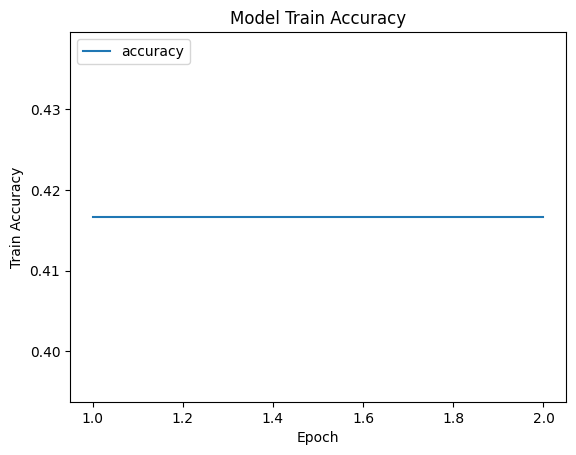

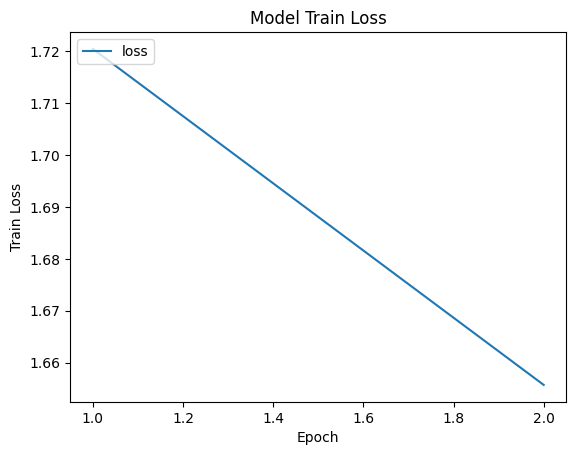

In [35]:
%matplotlib inline
plot_graph(history_dataframe,'Model Train Accuracy','Epoch','Train Accuracy',['accuracy'])
plot_graph(history_dataframe,'Model Train Loss','Epoch','Train Loss',['loss'])

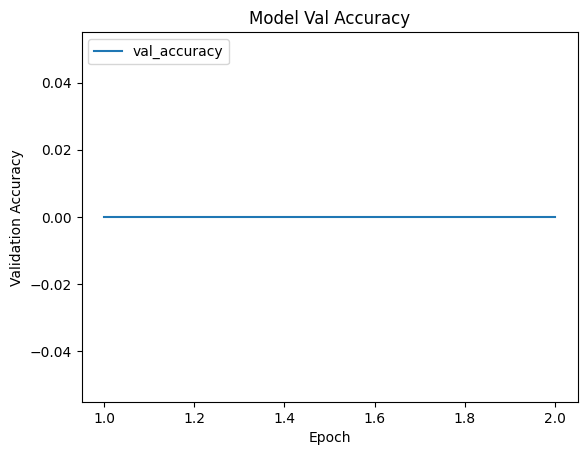

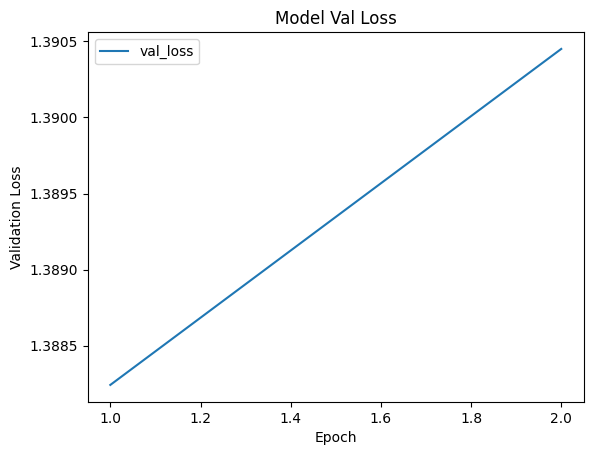

In [36]:
plot_graph(history_dataframe,'Model Val Accuracy','Epoch','Validation Accuracy',['val_accuracy'])
plot_graph(history_dataframe,'Model Val Loss','Epoch','Validation Loss',['val_loss'])

In [37]:
VARIETIES

['DBW 187', 'DBW222', 'HD 3086', 'PBW 291']

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

1/1 [==============================] - 2s 2s/step


In [39]:
y_pred_label = np.argmax(y_pred, axis=1)

In [40]:
# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.25
Confusion Matrix:
[[0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]
 [0 0 4 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.25      1.00      0.40         4
           3       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.06      0.25      0.10        16
weighted avg       0.06      0.25      0.10        16



C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

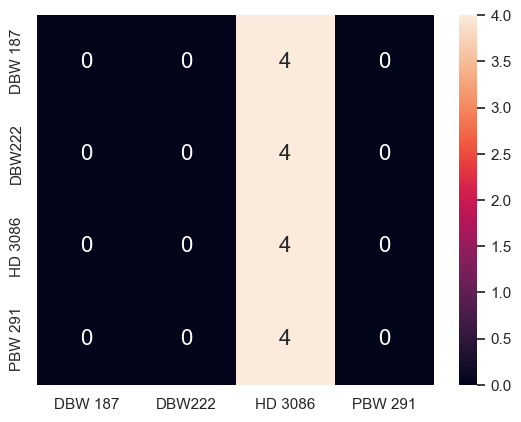

In [47]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()